In [2]:
import os
import pandas as pd
import tensorflow as tf
from keras import Model
from keras.models import  Sequential
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [3]:
def load_data(dataset_path):
    def extract_age(file_name):
        return int(file_name.split('_')[0])

    def extract_file_path(file_name):
        return os.path.join(dataset_path, file_name)

    file_names = os.listdir(dataset_path)
    ages = pd.Series(file_names).apply(extract_age)
    file_paths = pd.Series(file_names).apply(extract_file_path)

    df = pd.DataFrame({'Images': file_paths, 'Ages': ages})

    return df


dataset_path = './Datasets/imdbwiki-200-fixed/'
df = load_data(dataset_path)

dataset_path = './Datasets/UTKFace/'

#df = load_data(dataset_path)

df = pd.concat([df,load_data(dataset_path)])
df # 100k images




,Images,Ages
0,./Datasets/imdbwiki-200-fixed/45_nm0000171_rm4...,45
1,./Datasets/imdbwiki-200-fixed/45_nm0604448_rm1...,45
2,./Datasets/imdbwiki-200-fixed/41_35847230_1972...,41
3,./Datasets/imdbwiki-200-fixed/15_nm1767820_rm3...,15
4,./Datasets/imdbwiki-200-fixed/19_nm0334159_rm5...,19
...,...,...
23703,./Datasets/UTKFace/26_0_1_20170116204952113.jp...,26
23704,./Datasets/UTKFace/59_1_2_20170104212726717.jp...,59
23705,./Datasets/UTKFace/56_1_0_20170104185820366.jp...,56
23706,./Datasets/UTKFace/40_0_0_20170117121759794.jp...,40


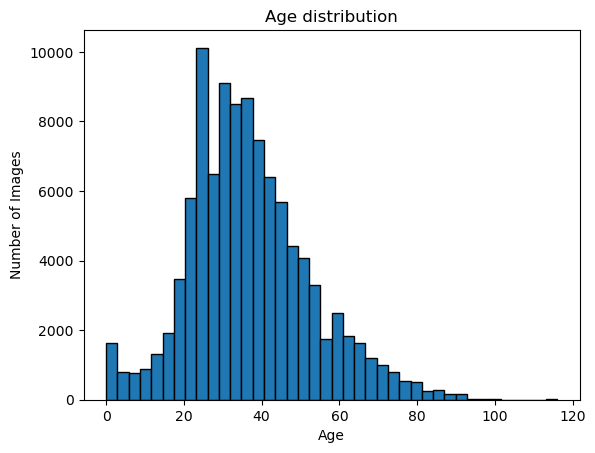

In [4]:
plt.hist(df['Ages'], bins=40, edgecolor='black')
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Number of Images')
plt.show()

In [5]:
from sklearn.utils import resample

# define maximum number of samples to keep

# Split dataframe into several based on 'Ages'
dfs = [x for _, x in df.groupby('Ages')]

# Resample each dataframe
for i in range(len(dfs)):
    if i>80 or i<1:
        dfs[i] = None
    elif dfs[i].shape[0] < 2:
        dfs[i] = None

# Concatenate dataframes
df = pd.concat(dfs)  # 23k images


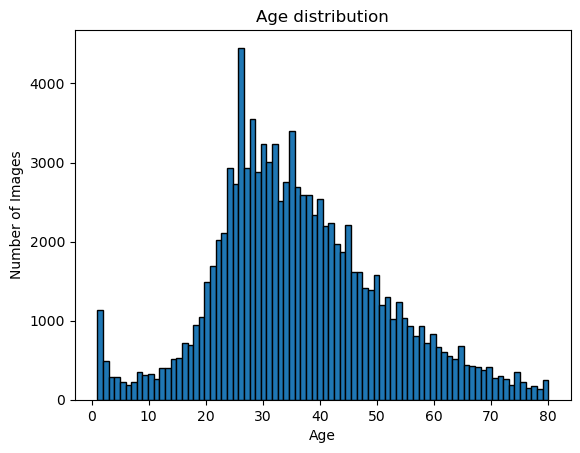

In [6]:
plt.hist(df['Ages'], bins=80, edgecolor='black')
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Number of Images')
plt.show()


In [7]:
from sklearn.utils import resample
import cv2
import numpy as np
import pandas as pd


def variance_of_laplacian(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()


def get_image_var(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return variance_of_laplacian(gray)


max_samples = 1000

# Calculate variance of laplacian for each image and add to new column 'image_var'
df['image_var'] = df['Images'].apply(get_image_var)

# Split dataframe into several based on 'Ages'
dfs = [x for _, x in df.groupby('Ages')]

# Resample each dataframe
for i in range(len(dfs)):
    if dfs[i].shape[0] > max_samples:
        # Sort by 'image_var' column and reset index
        dfs[i] = dfs[i].sort_values(
            'image_var', ascending=False).reset_index(drop=True)
        # Resample the first 'max_samples' rows after sorting
        dfs[i] = resample(dfs[i].iloc[:max_samples, :],
                          replace=False, n_samples=max_samples, random_state=124)

df_downsampled = pd.concat(dfs)


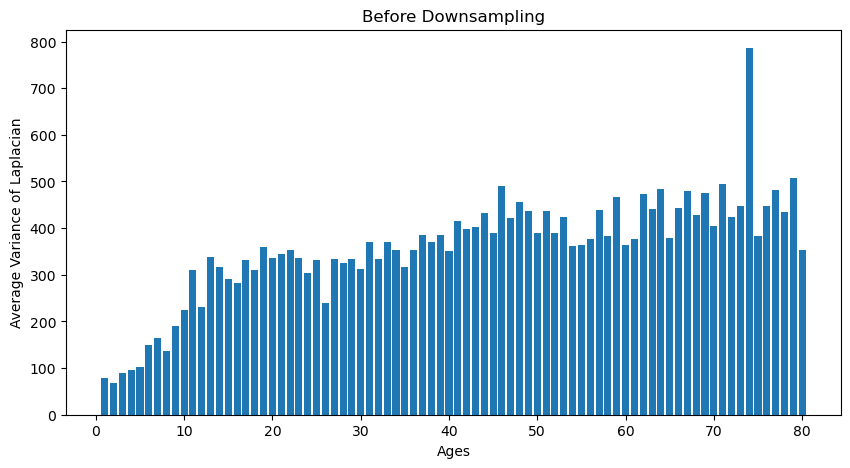

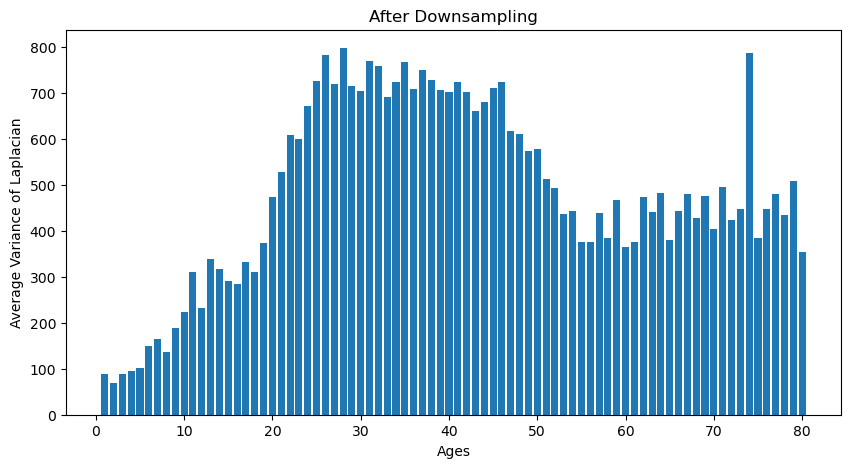

In [8]:
import matplotlib.pyplot as plt

average_var_before = df.groupby('Ages')['image_var'].mean()

# Calculate average variance of laplacian for each age group after downsampling
average_var_after = df_downsampled.groupby('Ages')['image_var'].mean()

# Convert series to dataframe for easier plotting
average_var_before = average_var_before.reset_index()
average_var_after = average_var_after.reset_index()

# Plot before downsampling
plt.figure(figsize=(10, 5))
plt.bar(average_var_before['Ages'], average_var_before['image_var'])
plt.xlabel('Ages')
plt.ylabel('Average Variance of Laplacian')
plt.title('Before Downsampling')
plt.show()

# Plot after downsampling
plt.figure(figsize=(10, 5))
plt.bar(average_var_after['Ages'], average_var_after['image_var'])
plt.xlabel('Ages')
plt.ylabel('Average Variance of Laplacian')
plt.title('After Downsampling')
plt.show()


In [9]:
df_downsampled

,Images,Ages,image_var
80,./Datasets/UTKFace/1_0_3_20161220221723490.jpg...,1,216.213870
789,./Datasets/UTKFace/1_0_2_20161219211707638.jpg...,1,21.367930
869,./Datasets/UTKFace/1_1_2_20161219192458643.jpg...,1,17.849174
518,./Datasets/UTKFace/1_1_0_20170109192729677.jpg...,1,39.878072
794,./Datasets/UTKFace/1_0_2_20161219194820459.jpg...,1,21.247380
...,...,...,...
22637,./Datasets/UTKFace/80_0_1_20170116003703261.jp...,80,368.087987
22901,./Datasets/UTKFace/80_0_0_20170117173759783.jp...,80,55.670891
22990,./Datasets/UTKFace/80_0_0_20170117175134292.jp...,80,49.548661
23387,./Datasets/UTKFace/80_1_0_20170110131358567.jp...,80,35.838599


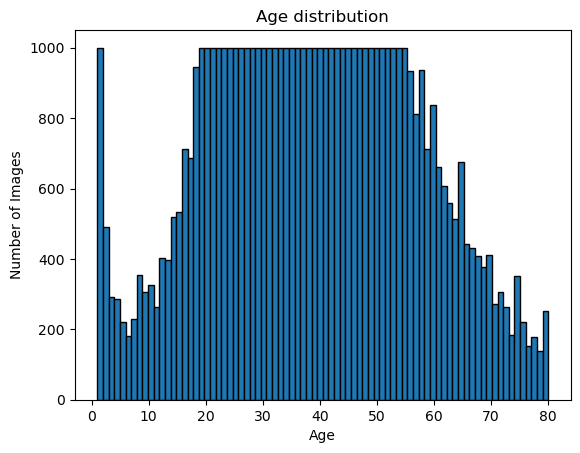

In [10]:
plt.hist(df_downsampled['Ages'], bins=80, edgecolor='black')
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Number of Images')
plt.show()

In [11]:
train_df, test_df = train_test_split(df, stratify=df['Ages'], test_size=0.2, random_state=42)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)



train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Images',
    y_col='Ages',
    target_size=(200,200),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=32
)

validation_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Images',
    y_col='Ages',
    target_size=(200,200),
    color_mode='grayscale',
    shuffle=False,
    class_mode='raw',
    batch_size=32,
)

Found 81984 validated image filenames.
Found 20496 validated image filenames.


In [ ]:
#train_generator.next()

In [ ]:
# for img,label in next(train_generator):
#         plt.imshow(img.astype('uint8'))  # convert float image to int for display
#         plt.show()
#         input()

In [ ]:
# import cv2
# import matplotlib.pyplot as plt
# import os
# import random

# # Set the path to the directory containing the images
# path_to_images = "./Datasets/imdbwiki-faces"

# # Get a list of all image filenames in the directory
# image_filenames = os.listdir(path_to_images)

# # Choose a random filename
# while True:
#     random_filename = random.choice(image_filenames)

#     # Construct the full path to the image
#     full_image_path = os.path.join(path_to_images, random_filename)

#     # Read the image using OpenCV
#     image = cv2.imread(full_image_path)

#     # Convert the image from BGR to RGB
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#     # Display the image using matplotlib
#     plt.imshow(image)
#     plt.show()
#     input()

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPool2D, AveragePooling2D, GlobalAveragePooling2D, Dense


def identity_block(X, filters, kernel_regularizer):
    shortcut = X

    X = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1),
               padding='same', kernel_regularizer=kernel_regularizer)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1),
               padding='same', kernel_regularizer=kernel_regularizer)(X)
    X = BatchNormalization()(X)

    X = Add()([X, shortcut])
    X = Activation('relu')(X)

    return X


def convolutional_block(X, filters, kernel_regularizer):
    shortcut = Conv2D(filters, kernel_size=(
        1, 1), strides=(2, 2), padding='valid')(X)
    shortcut = BatchNormalization()(shortcut)

    X = Conv2D(filters, kernel_size=(3, 3), strides=(2, 2),
               padding='same', kernel_regularizer=kernel_regularizer)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1),
               padding='same', kernel_regularizer=kernel_regularizer)(X)
    X = BatchNormalization()(X)

    X = Add()([X, shortcut])
    X = Activation('relu')(X)

    return X


def ResNet34(input_shape, l2_lambda=0.0001):
    X_input = Input(input_shape)

    X = Conv2D(64, kernel_size=(7, 7), strides=(2, 2),
               padding='same', kernel_regularizer=l2(l2_lambda))(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool2D((3, 3), strides=(2, 2), padding='same')(X)

    X = convolutional_block(X, 64, kernel_regularizer=l2(l2_lambda))
    X = identity_block(X, 64, kernel_regularizer=l2(l2_lambda))
    X = identity_block(X, 64, kernel_regularizer=l2(l2_lambda))

    X = convolutional_block(X, 128, kernel_regularizer=l2(l2_lambda))
    X = identity_block(X, 128, kernel_regularizer=l2(l2_lambda))
    X = identity_block(X, 128, kernel_regularizer=l2(l2_lambda))
    X = identity_block(X, 128, kernel_regularizer=l2(l2_lambda))

    X = convolutional_block(X, 256, kernel_regularizer=l2(l2_lambda))
    X = identity_block(X, 256, kernel_regularizer=l2(l2_lambda))
    X = identity_block(X, 256, kernel_regularizer=l2(l2_lambda))
    X = identity_block(X, 256, kernel_regularizer=l2(l2_lambda))
    X = identity_block(X, 256, kernel_regularizer=l2(l2_lambda))
    X = identity_block(X, 256, kernel_regularizer=l2(l2_lambda))

    X = convolutional_block(X, 512, kernel_regularizer=l2(l2_lambda))
    X = identity_block(X, 512, kernel_regularizer=l2(l2_lambda))
    X = identity_block(X, 512, kernel_regularizer=l2(l2_lambda))

    X = GlobalAveragePooling2D()(X)

    X = Dense(1, kernel_initializer='he_normal', activation='relu',
              kernel_regularizer=l2(l2_lambda))(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet34')

    return model


model = ResNet34((200, 200, 1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
agemodel = model


2023-06-14 10:22:33.889170: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-14 10:22:34.043334: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-14 10:22:34.043536: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [45]:
#agemodel.compile(optimizer=opt, loss='mse', metrics=['mae'])


In [20]:
agemodel.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 100, 100, 64  3200        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 100, 100, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                          

In [13]:
import math
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=math.sqrt(0.1), patience=6, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

early_stopping = EarlyStopping(monitor='val_loss', patience=9, verbose=1, mode='min', restore_best_weights=True)

model_dir = './Models'
os.makedirs(model_dir, exist_ok=True)

# Check if file exists and create new filename if necessary
base_model_name = "best_model"
suffix = 0
while True:
    model_name = f"{base_model_name}_{suffix}.h5" if suffix > 0 else f"{base_model_name}.h5"
    model_path = os.path.join(model_dir, model_name)
    if not os.path.exists(model_path):
        break
    suffix += 1

model_checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks = [early_stopping, lr_scheduler, model_checkpoint]


In [ ]:
#agemodel = keras.models.load_model('Models/regression_mp_5_24.h5')
#agemodel.summary()

In [47]:
# from keras import backend as K
# K.set_value(agemodel.optimizer.learning_rate, 0.001)


In [14]:
history = agemodel.fit(
    train_generator,
    epochs=512,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/512


2023-06-14 10:23:05.722893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-14 10:23:12.323713: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-14 10:23:13.630317: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-14 10:23:13.631807: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x3472ca00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-14 10:23:13.631820: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2023-06-14 10:23:13.650781: I

2562/2562 [==============================] - ETA: 0s - loss: 213.8391 - mae: 11.1284

2023-06-14 10:26:09.837213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 588.36353, saving model to ./Models/best_model_29.h5
2562/2562 [==============================] - 199s 70ms/step - loss: 213.8391 - mae: 11.1284 - val_loss: 588.3635 - val_mae: 20.3491 - lr: 0.0010
Epoch 2/512
2562/2562 [==============================] - ETA: 0s - loss: 133.4194 - mae: 8.8703
Epoch 2: val_loss improved from 588.36353 to 542.36060, saving model to ./Models/best_model_29.h5
2562/2562 [==============================] - 179s 70ms/step - loss: 133.4194 - mae: 8.8703 - val_loss: 542.3606 - val_mae: 19.3388 - lr: 0.0010
Epoch 3/512
2562/2562 [==============================] - ETA: 0s - loss: 119.5568 - mae: 8.2975
Epoch 3: val_loss improved from 542.36060 to 141.08264, saving model to ./Models/best_model_29.h5
2562/2562 [==============================] - 179s 70ms/step - loss: 119.5568 - mae: 8.2975 - val_loss: 141.0826 - val_mae: 8.8904 - lr: 0.0010
Epoch 4/512
2562/2562 [==============================] - ETA: 0s - loss: 107.8965 - mae

In [24]:
# agemodel.load_weights("model_path")
#all_datagen = ImageDataGenerator(rescale=1./255)
#all_generator = all_datagen.flow_from_dataframe(
#     dataframe=df,
#     x_col='Images',
#     y_col='Ages',
#     target_size=(200, 200),
#     color_mode='grayscale',
#     class_mode='raw',
#     shuffle=False,
#     batch_size=32
# )
predicted_ages = agemodel.predict(validation_generator)

#rain_df.reset_index(drop=True, inplace=True)

mse = mean_squared_error(test_df['Ages'], predicted_ages)
mae = mean_absolute_error(test_df['Ages'], predicted_ages)

print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)

  7/641 [..............................] - ETA: 13s

2023-06-14 12:22:41.769586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


641/641 [==============================] - 13s 21ms/step
Mean Squared Error: 67.32383802096658
Mean Absolute Error: 5.946214019419054


In [26]:
import numpy as np
# Reset the DataFrame's index
df.reset_index(drop=True, inplace=True)

# Ensure predicted_ages is a 1D array
predicted_ages = np.squeeze(predicted_ages)

# Calculate the absolute errors
absolute_errors = np.abs(test_df['Ages'] - predicted_ages)


ValueError: 4 is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

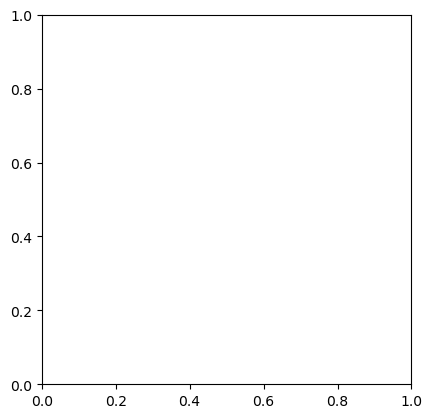

In [27]:
import matplotlib.pyplot as plt
import cv2 

# Calculate the absolute errors
#absolute_errors = np.abs(test_df['Ages'] - predicted_ages)

# Find the index of the max error
max_error_idx = np.argmax(absolute_errors)

# Assuming validation_generator yields a tuple (images, labels) and the images are in the same order as in test_df
# Also assuming it hasn't been iterated over already in your current program run. If it has, you may need to reset the generator.
for i, (images, labels) in enumerate(validation_generator):
    if i == max_error_idx:
        # assuming images is a batch with our desired image as the first entry
        max_error_image = images[0]
        break

# Plot the image
plt.imshow(max_error_image, cv2.COLOR_BGR2RGB)
plt.title(
    f"Largest error image with age {df['Ages'].iloc[max_error_idx]} and predicted age {predicted_ages[max_error_idx]}")
plt.show()


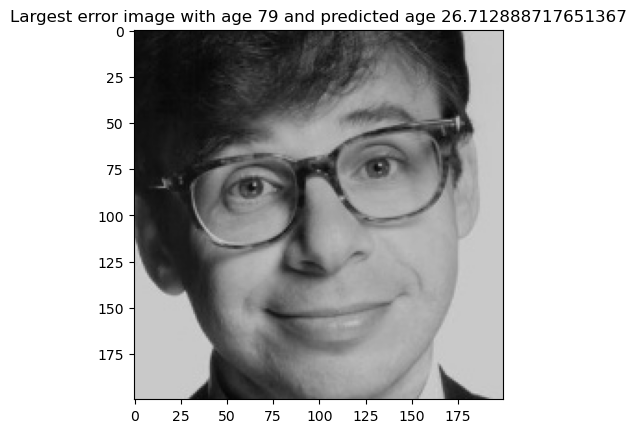

In [28]:
plt.imshow(cv2.cvtColor(max_error_image, cv2.COLOR_BGR2RGB))
plt.title(
    f"Largest error image with age {test_df['Ages'].iloc[max_error_idx]} and predicted age {predicted_ages[max_error_idx]}")
plt.show()


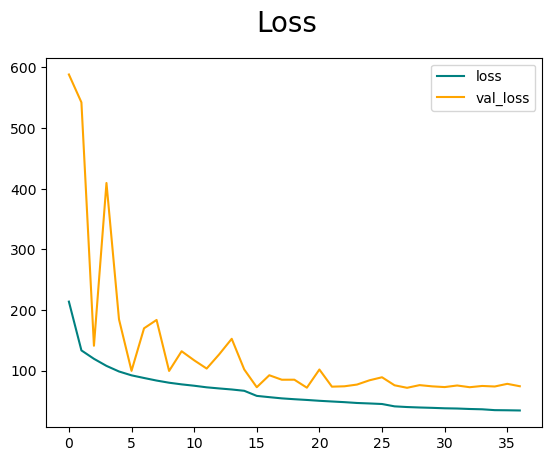

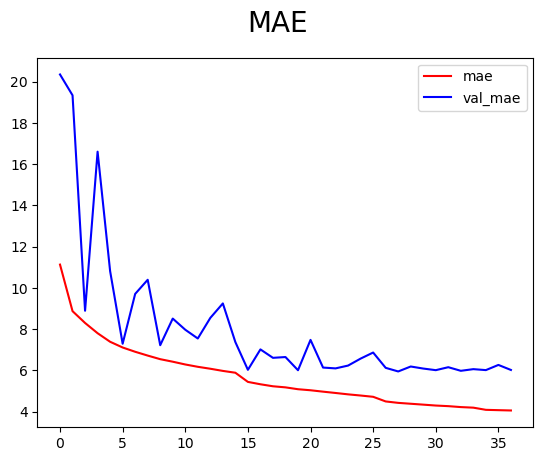

In [15]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
fig2 = plt.figure()
plt.plot(history.history['mae'], color='red', label='mae')
plt.plot(history.history['val_mae'], color='blue', label='val_mae')
fig2.suptitle('MAE', fontsize=20)
plt.legend(loc="upper right")
plt.show()


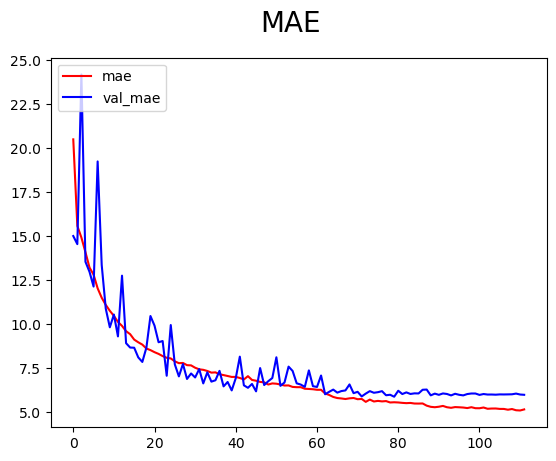

In [24]:
# fig = plt.figure()
# plt.plot(history.history['mae'], color='red', label='mae')
# plt.plot(history.history['val_mae'], color='blue', label='val_mae')
# fig.suptitle('MAE', fontsize=20)
# plt.legend(loc="upper right")
# plt.show()

In [43]:
new_model = tf.keras.models.load_model(
    'Models/regression_efficientNet_mp_4_99.h5')


In [26]:
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 200, 200, 32)      832       
                                                                 
 batch_normalization_30 (Bat  (None, 200, 200, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 200, 200, 32)      25632     
                                                                 
 batch_normalization_31 (Bat  (None, 200, 200, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                      

In [44]:
predicted_ages = model.predict(validation_generator)

mse = mean_squared_error(test_df['Ages'], predicted_ages)
mae = mean_absolute_error(test_df['Ages'], predicted_ages)

print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)


2023-06-13 08:57:27.085395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


320/320 [==============================] - 9s 25ms/step
Mean Squared Error: 121.6218245905298
Mean Absolute Error: 8.389958673074053


In [16]:
agemodel.save(os.path.join('Models', 'resnet34.h5'))